In [28]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize

rf_rate = yf.download('^IRX').iloc[-1, 3] / 100
print('Risk-free rate: {:.2f}%'.format(rf_rate * 100))

def Sharpe(data, weights, rf_rate=0):
    mean = np.mean(data, axis=0)
    return (mean - rf_rate) @ weights / np.sqrt(weights @ np.cov(data.T) @ weights)

[*********************100%%**********************]  1 of 1 completed
Risk-free rate: 5.21%


# Zadanie 3
## teoria portfelowa i badanie efektu dywersyfikacji

Korzystając z modelu Markowitza, proszę o analizę relacji potencjalnego zysku do ryzyka w odniesieniu do portfela złożonego z ryzykownych instrumentów finansowych. Proszę wyznaczyć zbiór portfeli efektywnych (efficient portfolios) oraz granicę efektywną (efficient frontier).

### Wizualizacja szeregów czasowych

[*********************100%%**********************]  4 of 4 completed


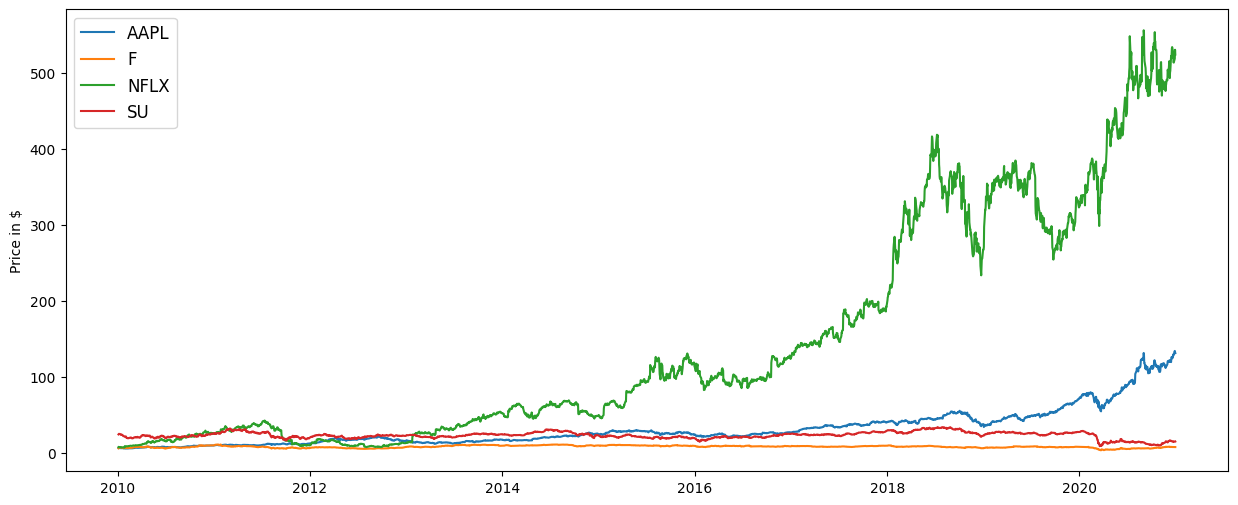

Text(0, 0.5, 'Daily returns')

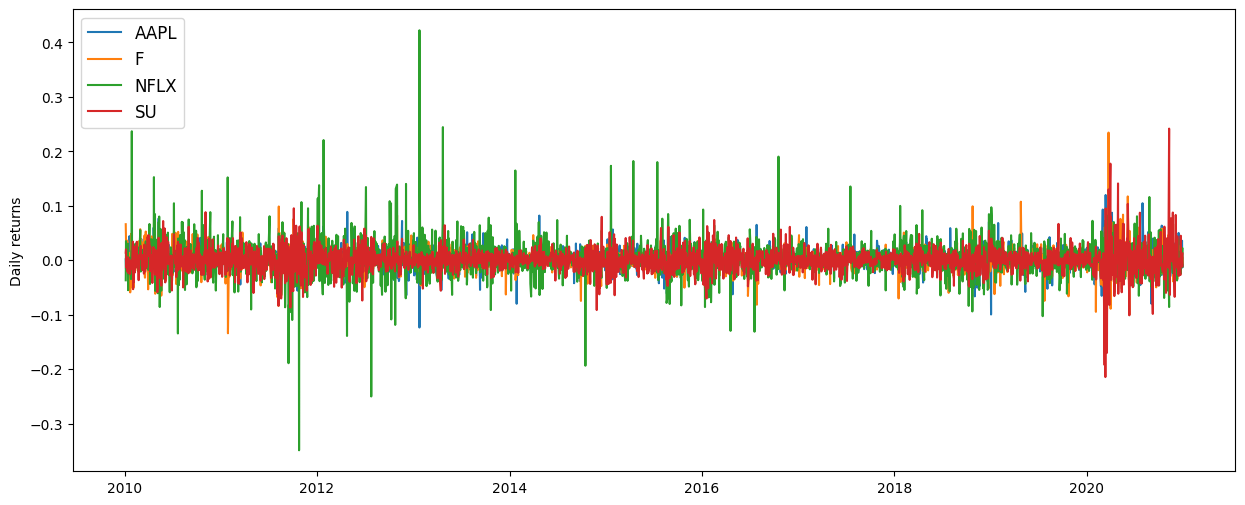

In [29]:
data = yf.download('F AAPL NFLX SU', start='2010-01-01', end='2020-12-31')['Adj Close'].dropna()

plt.figure(figsize=(15, 6))
for i in range(data.shape[1]):
    plt.plot(data.iloc[:,i], label=data.columns.values[i])
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')
plt.show()

plt.figure(figsize=(15, 6))
returns = data.pct_change().dropna()
for i in range(returns.shape[1]):
    plt.plot(returns.iloc[:,i], label=returns.columns.values[i])
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Daily returns')

In [30]:
annual_mean_return = returns.mean() * 252
returns_covariance = returns.cov()

print('Annual mean return:\n', annual_mean_return, '\n')
print('Covariance matrix:\n', returns_covariance)

Annual mean return:
 AAPL    0.314360
F       0.071013
NFLX    0.517320
SU      0.020288
dtype: float64 

Covariance matrix:
           AAPL         F      NFLX        SU
AAPL  0.000318  0.000133  0.000146  0.000131
F     0.000133  0.000391  0.000108  0.000202
NFLX  0.000146  0.000108  0.001055  0.000112
SU    0.000131  0.000202  0.000112  0.000512


### przydatne funkcje

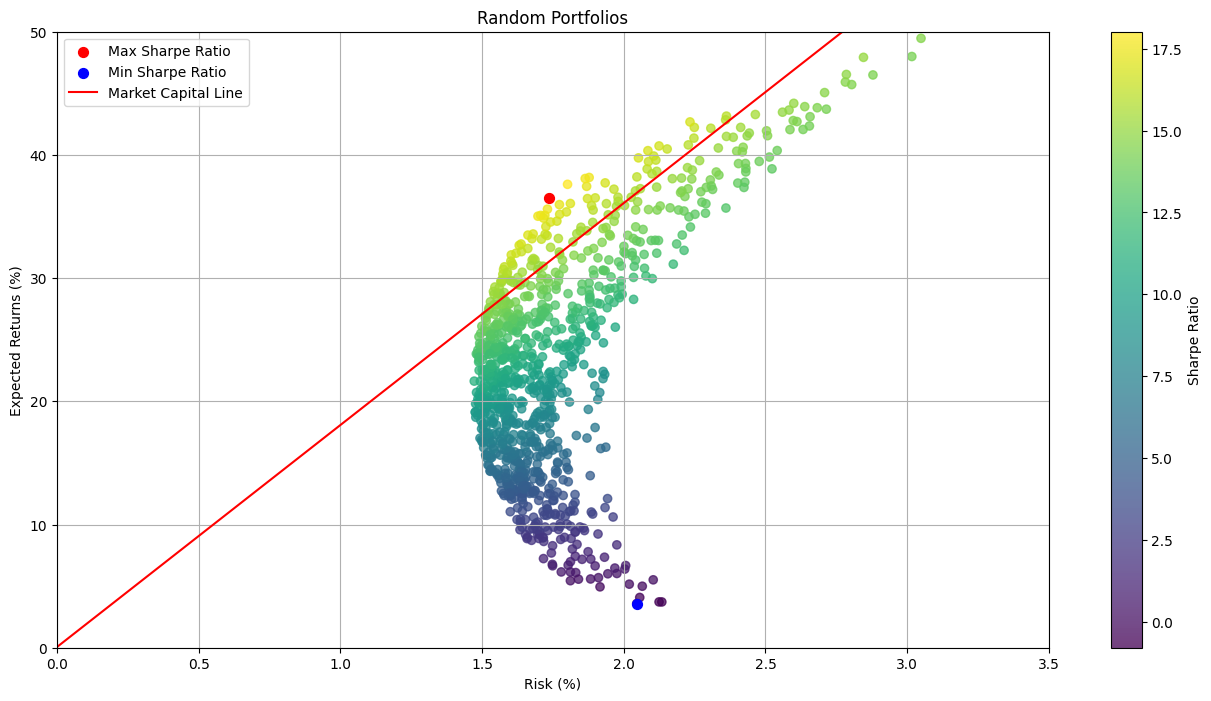

In [31]:
N_PORTFOLIOS = 1000

def generate_portfolios(mean_returns, cov_matrix):
    returns = []
    risks = []
    sharpes = []
    weights = []
    for _ in range(N_PORTFOLIOS):
        weights.append(np.random.dirichlet(np.ones(mean_returns.shape[0]), size=1)[0])
        returns.append(weights[-1] @ mean_returns)
        risks.append(np.sqrt(weights[-1].T @ cov_matrix @ weights[-1]))
        sharpes.append((returns[-1] - rf_rate) / risks[-1])
    returns = np.array(returns)
    risks = np.array(risks)
    plt.scatter(
        risks * 100.0,
        returns * 100.0,
        c=sharpes,
        cmap="viridis",
        alpha=0.75,
    )
    plt.xlabel("Risk (%)")
    plt.ylabel("Expected Returns (%)")
    plt.colorbar(label="Sharpe Ratio")
    plt.grid()
    return risks, returns, sharpes

# market capital line
def generate_mcl(mean_returns, cov_matrix):
    risks, returns, sharpes = generate_portfolios(mean_returns, cov_matrix)
    max_sharpe_idx = np.argmax(sharpes)
    min_sharpe_idx = np.argmin(sharpes)
    plt.scatter(
        risks[max_sharpe_idx] * 100.0,
        returns[max_sharpe_idx] * 100.0,
        c="red",
        s=50,
        label="Max Sharpe Ratio",
    )
    plt.scatter(
        risks[min_sharpe_idx] * 100.0,
        returns[min_sharpe_idx] * 100.0,
        c="blue",
        s=50,
        label="Min Sharpe Ratio",
    )
    x = np.linspace(0, 100, 100)
    y = rf_rate + (returns[max_sharpe_idx] - rf_rate) / risks[max_sharpe_idx] * x
    plt.plot(x, y, c="red", label="Market Capital Line")
    plt.legend(loc="upper left")

plt.figure(figsize=(16, 8))
plt.title("portfolio optimization")
generate_mcl(annual_mean_return, returns_covariance)
plt.ylim(0, 50)
plt.xlim(0, 3.5)
plt.show()